# Binocular

We explore a different approach of training per patient by loading both left and right image and train efficient net b0 

We also treat ODIR as multi-label problem instead of multi-class as originally it is officially a multi-label problem
from https://odir2019.grand-challenge.org/dataset/
> Note: one patient may contains one or multiple labels. 

We also want to explore binocular or siamese approach to train our model on both left and right fundus image pair. This has been researched in https://arxiv.org/html/2504.18046v3 DMS-Net:Dual-Modal Multi-Scale Siamese Network for Binocular: Fundus Image Classification Guohao Huo, Zibo Lin, Zitong Wang, Ruiting Dai, Hao Tang paper to work well for fundus disease classification 

There are 3 advantages of use both eyes images instead of one eye image :
- Symmetry: Diseases like Diabetes aren't "accidents" in one eye; they are systemic. If the AI sees it in both, it's a "confirmed" diagnosis.

- Comparison: The left eye acts as a "control" for the right eye. AI can spot a tiny change by noticing how much it differs from the other eye.

- Noise Reduction: Just like your two eyes help you see depth, two images help the AI ignore "camera blur" or "dust" on one lens that might look like a disease.

Install Dependencies

In [11]:
%%capture
!pip install -q kagglehub torch torchvision scikit-learn pandas opencv-python tqdm wandb

Import python libraries

In [12]:

import os
import cv2
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, multilabel_confusion_matrix, accuracy_score
import kagglehub
from tqdm import tqdm # tqdm for progress bars
import wandb


Download DataSet

In [13]:
# 1. Download Dataset (Official ODIR-5K)
path = kagglehub.dataset_download("andrewmvd/ocular-disease-recognition-odir5k")
print("Dataset path:", path)
IMG_DIR = os.path.join(path, "ODIR-5K/ODIR-5K/Training Images")
CSV_PATH = os.path.join(path, "full_df.csv")
IMG_SIZE = 512
df = pd.read_csv(CSV_PATH)

Dataset path: /home/ray/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2


In [14]:
df.head()

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1   
4  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
3  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
4  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg  
2  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg  
3  [0, 1, 0, 0, 0, 0, 0, 0]  4_right.jpg  
4  [0, 1, 0, 0, 0, 0, 0, 0]  5_right.jpg

## Ben Graham's Preprocessing

This function implements the Ben Graham Preprocessing 
ref : 
- https://scholar.google.com/citations?view_op=view_citation&hl=en&user=jQkkhlkAAAAJ&citation_for_view=jQkkhlkAAAAJ:sNmaIFBj_lkC
- https://scholar.google.com/citations?user=jQkkhlkAAAAJ&hl=en
- https://arxiv.org/abs/2303.00915 usuyama variation


From https://medium.com/@astronomer.abdurrehman/enhancing-image-quality-for-machine-learning-ben-grahams-preprocessing-e795ad982abe
the method described as followed
<blockquote>

The cv2.GauissanBlur takes an image, (0, 0) tuple automatically chooses a gaussian filter size based on sigmaX value which specifies the intensity of blur. Goal of using gaussian blur here is to reduce the noise and smooth out the fine details.

The addWeighted function blends two images together using specified weights, the -4 here is the beta value which subtracts the blurred image from the original image and 128 is the gamma value that adjusts the brightness so that the image does not become too dark after subtraction.


</blockquote>


In [15]:
import cv2
import numpy as np

def resize_odir_image(img, target_size=512):
    """
    Combines Circular Cropping, Aspect-Ratio Resizing, and Padding.
    """
    # 1. Load and initial crop to remove obvious black dead space
    if img is None: return None
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Thresholding to find the retina boundary
    _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(mask)
    
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        img = img[y:y+h, x:x+w]

    # 2. Letterbox Resize (Preserve Aspect Ratio)
    h, w = img.shape[:2]
    scale = target_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Use INTER_AREA for high-quality downsampling
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # 3. Create Square Canvas and Center
    final_img = np.zeros((target_size, target_size, 3), dtype=np.uint8)
    offset_y = (target_size - new_h) // 2
    offset_x = (target_size - new_w) // 2
    final_img[offset_y:offset_y+new_h, offset_x:offset_x+new_w] = resized
    
    return final_img

In [16]:
def usuyama_prep(img):
    """Enhances vessels and normalizes lighting."""
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Circular Crop: Find non-black pixels and crop
    img = resize_odir_image(img, target_size=IMG_SIZE)  # Crop to circular region
    blurred = cv2.GaussianBlur(img, (0, 0), 10)
    enhanced = cv2.addWeighted(img, 4, blurred, -4, 128)
    return enhanced

In [17]:
def usuyama_green_prep(img):
    """Extracts the green channel and normalizes."""
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Circular Crop: Find non-black pixels and crop
    img = resize_odir_image(img, target_size=IMG_SIZE)  # Crop to circular region
    green_ch = img[:, :, 1]
    blurred = cv2.GaussianBlur(green_ch, (0, 0), 10)
    green_ben = cv2.addWeighted(green_ch, 4, blurred, -4, 128)
    
    # Convert to 3-channel for Model Input
    return cv2.merge([green_ben, green_ben, green_ben])

In [18]:
def hybrid_clahe_green_ben(img, clip_limit=2.0, grid_size=(8,8)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Circular Crop: Find non-black pixels and crop
    img = resize_odir_image(img, target_size=IMG_SIZE)  # Crop to circular region

    # 1. Green Channel
    green = img[:, :, 1]
    
    # 2. CLAHE (Do this first to boost local signal)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    enhanced_green = clahe.apply(green)
    
    # 3. Milder Ben Graham (Usuyama style)
    # This cleans up any "glow" the CLAHE might have amplified
    blurred = cv2.GaussianBlur(enhanced_green, (0, 0), 10)
    final = cv2.addWeighted(enhanced_green, 4, blurred, -4, 128)
    
    return cv2.merge([final, final, final])

In [19]:
def color_clahe(img, clip_limit=2.0):
    # Convert to LAB (L is Lightness, A/B are color dimensions)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to L-channel only
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8,8))
    cl = clahe.apply(l)
    
    # Merge and convert back to BGR
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

def hybrid_clahe_usuyama_prep(img):
    """Enhances vessels and normalizes lighting."""
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Circular Crop: Find non-black pixels and crop
    img = resize_odir_image(img, target_size=IMG_SIZE)  # Crop to circular region
    img = color_clahe(img, clip_limit=2.0)  # First apply CLAHE to boost local contrast
    blurred = cv2.GaussianBlur(img, (0, 0), 10)
    enhanced = cv2.addWeighted(img, 4, blurred, -4, 128)
    return enhanced

On the fly image prep caused the training slowdown given the image need to be preprocessed repeatedly each time it is loaded. We speed up the process by performing preprocessing offline once and cache it

In [23]:
def run_offline_prep(df, raw_dir, img_prep_func, save_dir):
    print("🚀 Starting Offline Pre-processing (Ben Graham)...")
    os.makedirs(save_dir, exist_ok=True)
    all_images = pd.concat([df['Left-Fundus'], df['Right-Fundus']]).unique()
    existed=0
    missing=0
    for img_name in tqdm(all_images):
        save_path = os.path.join(save_dir, img_name)
        load_path = os.path.join(raw_dir, img_name)
        if os.path.exists(save_path):
            existed+=1
            continue
        if not os.path.exists(load_path):
            missing+=1
            continue
        img = cv2.imread(str(load_path))
        # Ben Graham Logic
        enhanced = img_prep_func(img)
        cv2.imwrite(save_path, cv2.cvtColor(enhanced, cv2.COLOR_RGB2BGR))
    print(f"✅ Pre-processing complete. {existed} images already existed, {missing} images were missing.")

In [ ]:
run_offline_prep(df, IMG_DIR, usuyama_prep, "tmp/usuyama_prep")
run_offline_prep(df, IMG_DIR, usuyama_green_prep, "tmp/usuyama_green_prep")
run_offline_prep(df, IMG_DIR, hybrid_clahe_usuyama_prep, "tmp/hybrid_clahe_usuyama_prep")
run_offline_prep(df, IMG_DIR, hybrid_clahe_green_ben, "tmp/hybrid_clahe_green_ben_prep")

🚀 Starting Offline Pre-processing (Ben Graham)...


100%|██████████| 6716/6716 [00:00<00:00, 385432.46it/s]


✅ Pre-processing complete. 6716 images already existed, 0 images were missing.
🚀 Starting Offline Pre-processing (Ben Graham)...


100%|██████████| 6716/6716 [00:00<00:00, 384354.35it/s]


✅ Pre-processing complete. 6716 images already existed, 0 images were missing.
🚀 Starting Offline Pre-processing (Ben Graham)...


100%|██████████| 6716/6716 [00:15<00:00, 438.53it/s]  


✅ Pre-processing complete. 6346 images already existed, 0 images were missing.
🚀 Starting Offline Pre-processing (Ben Graham)...


100%|██████████| 6716/6716 [04:02<00:00, 27.73it/s]

✅ Pre-processing complete. 0 images already existed, 0 images were missing.


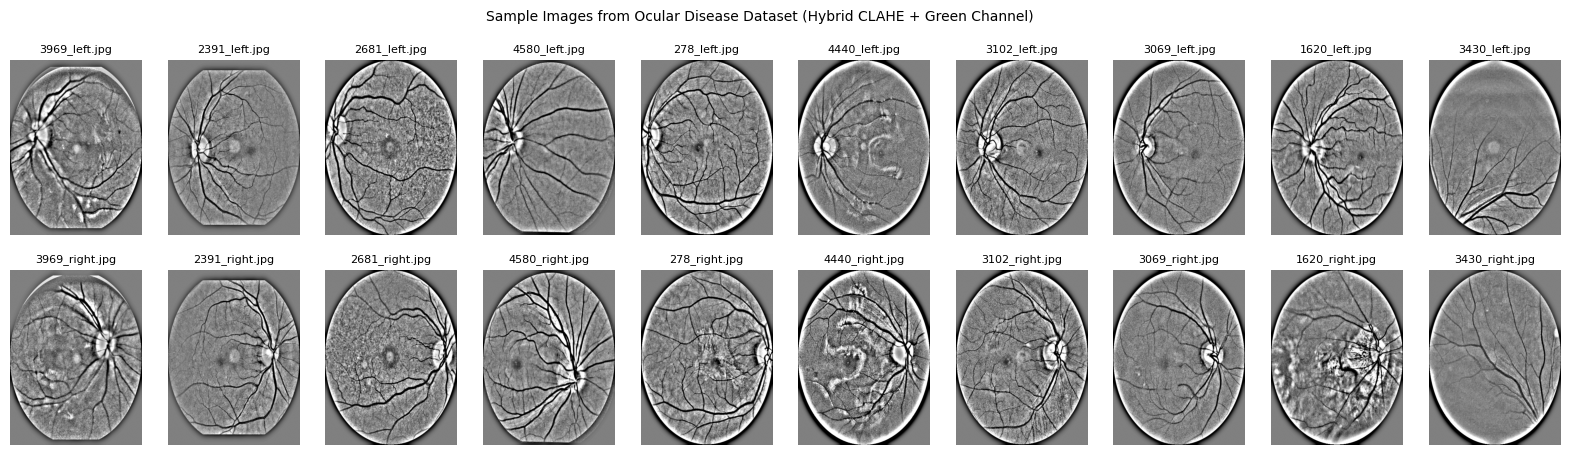

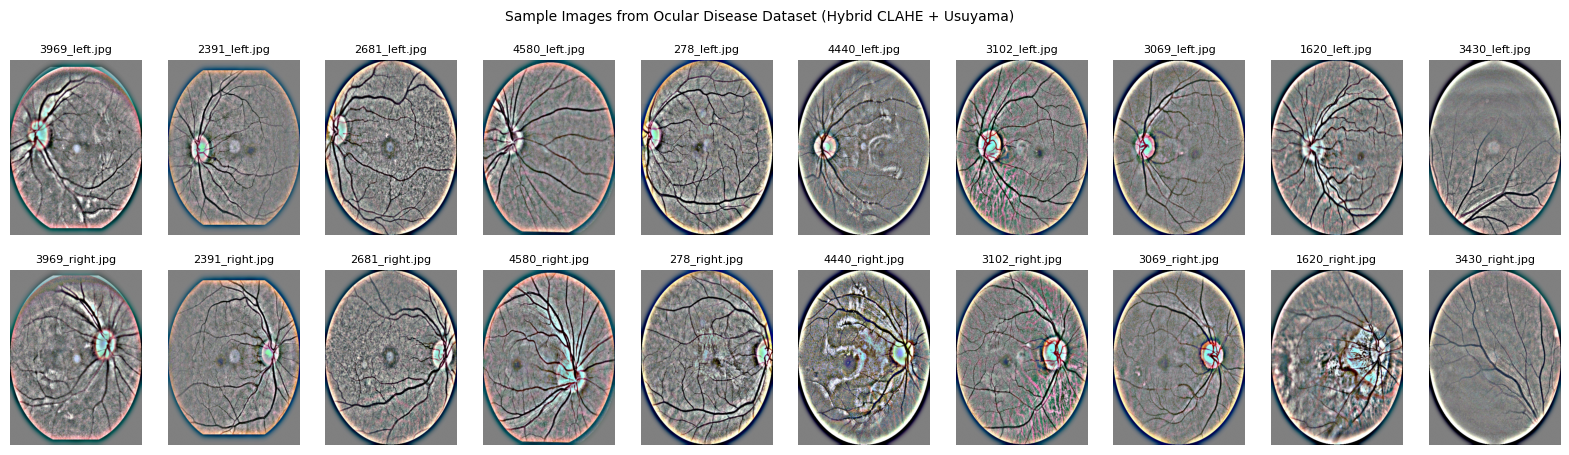

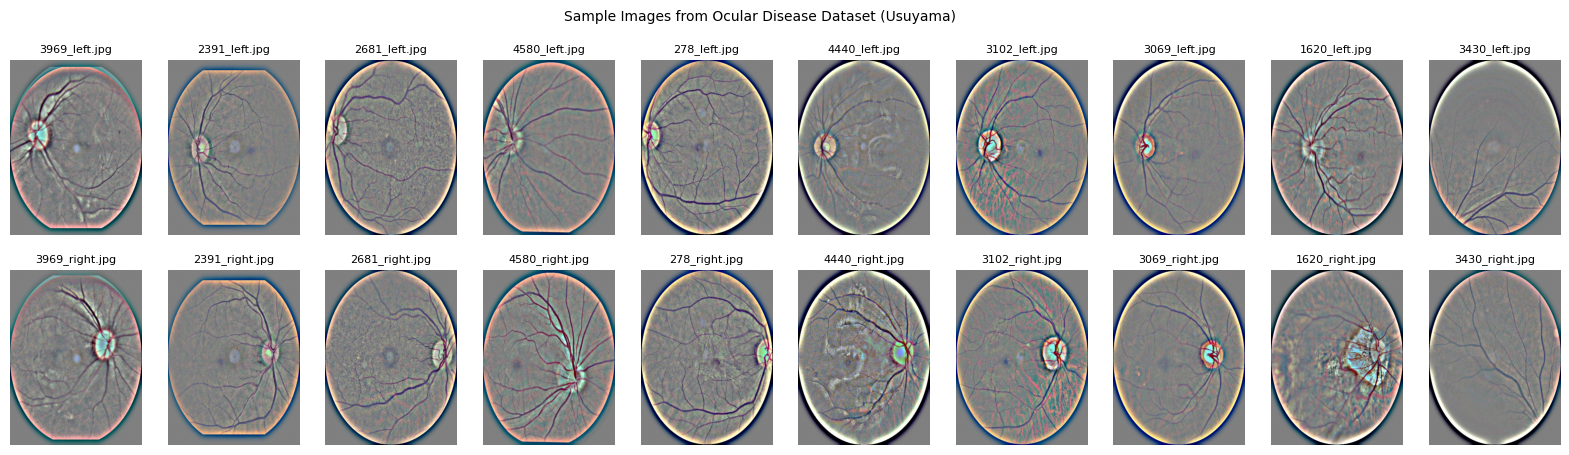

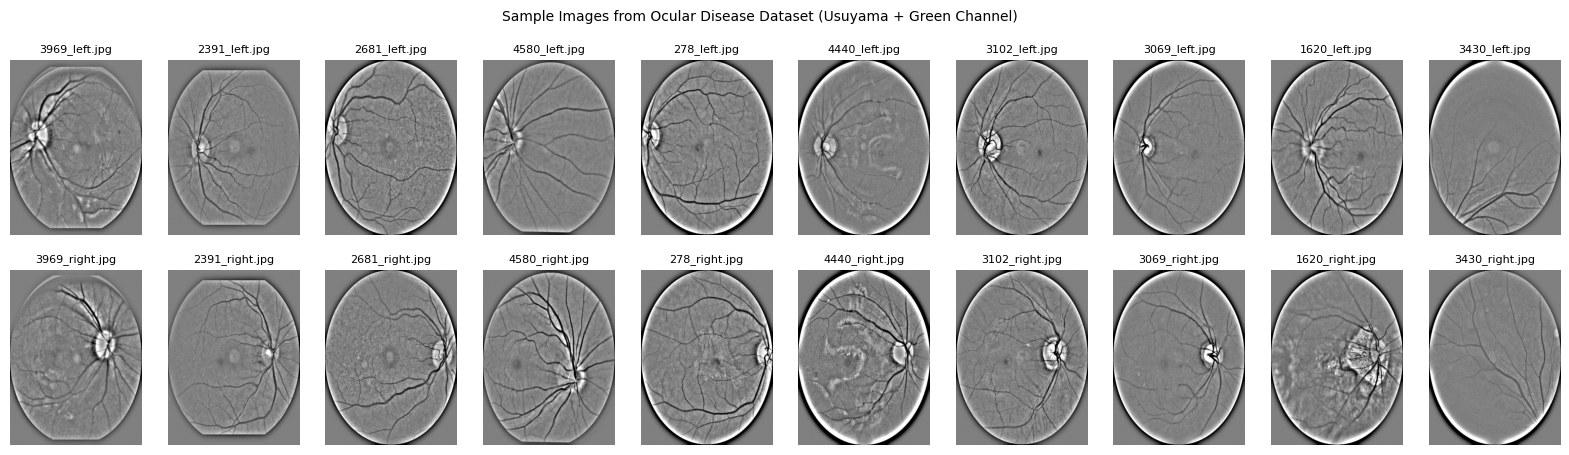

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
def display_images(image_dir,image_filenames:list[str], title="Image DataSet", col_count = 10, w=512, h=512):
    img_count = len(image_filenames)
    plt.figure(figsize=(20, 5))
    plt.suptitle(title, fontsize=10)
    row_count = (img_count + col_count - 1) // col_count  # Calculate number of rows needed
    for i in range(1, img_count+1):
        plt.subplot(row_count, col_count, i)
        image_path=os.path.join(image_dir, image_filenames[i-1])
        if not os.path.exists(image_path):
            print(f"Image file not found: {image_path}")
            continue
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (w, h))
        img = img / 255.
        plt.imshow(img, aspect="auto")
        plt.title(f"{image_filenames[i-1].split('/')[-1]}", fontsize=8)
        plt.axis(False);
    plt.show()

def display_sample_images(image_dir, sample_df, title="Sample Images from Ocular Disease Dataset", sample_size=10):
    left_fundus = sample_df['Left-Fundus'].tolist()
    right_fundus = sample_df['Right-Fundus'].tolist()
    image_filenames = left_fundus + right_fundus
    display_images(image_dir, image_filenames, title=title, col_count=sample_size)

sample_df = df.sample(10, random_state=42)
display_sample_images("tmp/hybrid_clahe_green_ben_prep", sample_df, title="Sample Images from Ocular Disease Dataset (Hybrid CLAHE + Green Channel)")
display_sample_images("tmp/hybrid_clahe_usuyama_prep", sample_df, title="Sample Images from Ocular Disease Dataset (Hybrid CLAHE + Usuyama)")
display_sample_images("tmp/usuyama_prep", sample_df, title="Sample Images from Ocular Disease Dataset (Usuyama)")
display_sample_images("tmp/usuyama_green_prep", sample_df, title="Sample Images from Ocular Disease Dataset (Usuyama + Green Channel)")

From our visual inspection above, we can see that Usuyama Green channel is more promising